# Character-Based Recurrent Neural Network

This notebook will build a character-based language model, using a recurrent neural network in PyTorch. This notebook should be accessible if you have tried a little [PyTorch](https://www.youtube.com/watch?v=v5cngxo4mIg&list=PLZbbT5o_s2xrfNyHZsM6ufI0iZENK9xgG), and if you are familliar with classical feed forward neural networks.

This notebook will build up to the RNN model in a series of steps:

- Create a Dataset
- Define a generic training loop
- 1-character feed-forward network
- 2-character feed-forward network
- N-character feed-forward network
- Using Pytorch's RNN module
- Training more efficiently
- Remembering

This approach is heavily based on [lesson 6](https://course.fast.ai/lessons/lesson6.html) of FastAI [Deep Learning for Coders](https://course.fast.ai/). It's only indirectly related to Kapathy's [char-rnn](https://github.com/karpathy/char-rnn) implementation. 

In [2]:
# Imports and notebook setup
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

# Create directory to store training data.
user_list = !whoami
username = user_list[0]
PATH = f'/home/{username}/data/char-rnn/'
os.makedirs(PATH, exist_ok=True)

In [3]:
# This notebook assumes that you have Nvidia CUDA available. If it is not, change all `.cuda()` calls to `.cpu()`
assert torch.cuda.is_available(), 'CUDA is not available.'
assert torch.backends.cudnn.enabled, 'CuDNN is not available.'

# Create a Dataset

Skip this if you don't care about PyTorch stuff, or where the data comes from.

We need to first get the training data. Below we create a subclass of `torch.Dataset`, which defines how to read the training data. I have not defined a test or validation dataset. In this particular case, `TextDataset` will download the full works of Nietzsche from S3 and load the text into memory for training.

In [4]:
import requests
import torch
from torch.utils.data import Dataset, DataLoader

SOURCE_URL = 'https://s3.amazonaws.com/text-datasets/nietzsche.txt'
TARGET_FILE = f'{PATH}nietzsche.txt'

class TextDataset(Dataset):
    def __init__(self, num_chars):
        """
        Argument 'num_chars' determines how many characters are used to predict the next character.
        """
        self.num_chars = num_chars
        self.fetch_file()
        self.load_text()
    
    def fetch_file(self):
        """
        Fetch dataset file from SOURCE_URL if it doesn't exist locally.
        """
        if not os.path.exists(TARGET_FILE):
            print(f'Downloading from S3...', end=' ')
            response = requests.get(SOURCE_URL, stream=True)
            response.raise_for_status()
            with open(TARGET_FILE, 'wb') as f:
                for block in response.iter_content(1024):
                    f.write(block)

            print('done')
    
    def load_text(self):
        """
        Load the text from disk and convert characters to integers with a mapping.
        """
        with open(TARGET_FILE) as f:
            self.text = f.read().lower()
        
        self.chars = sorted(list(set(self.text)))
        self.char_to_idx = {c: i for i, c in enumerate(self.chars)}
        self.idx_to_char = {i: c for i, c in enumerate(self.chars)}

    def __len__(self):
        """
        How many samples there are in the dataset.
        """
        return len(self.text) - self.num_chars - 1
    
    def __getitem__(self, idx):
        """
        Get item by integer index,
        returns (x_1, x_2, ..., x_n), y
        where x 1 to n are integers representing the input characters
        and y is an integer the output character
        """
        inputs = torch.tensor([self.char_to_idx[c] for c in self.text[idx:idx + self.num_chars]])
        label = self.char_to_idx[self.text[idx + self.num_chars]]
        return inputs, label

In [5]:
# We can test out how the Dataset__getitem__ method works
train_ds = TextDataset(num_chars=3)
print('Source text:', repr(train_ds.text[:20]))
print('Int form:', [train_ds.char_to_idx[c] for c in train_ds.text[:20]])
for i in range(5):
    xs, y = train_ds[i]
    print('Sample', i, '- input', xs, 'label', y)

Source text: 'preface\n\n\nsupposing '
Int form: [42, 44, 31, 32, 27, 29, 31, 0, 0, 0, 45, 47, 42, 42, 41, 45, 35, 40, 33, 1]
Sample 0 - input tensor([42, 44, 31]) label 32
Sample 1 - input tensor([44, 31, 32]) label 27
Sample 2 - input tensor([31, 32, 27]) label 29
Sample 3 - input tensor([32, 27, 29]) label 31
Sample 4 - input tensor([27, 29, 31]) label 0


# Define a generic training loop

Skip this if you don't care how the models get trained.

Here we'll define a generic training loop which can be applied to all models. Below we define:

- `ProgressBar` - a helper class for printing stuff
- `train_net` - a training loop function that accepts a model and some hyperparameters as input


In [6]:
from tqdm import tqdm_notebook as tqdm

class ProgressBar():
    """
    Pretty progress bar for training - not super relevant.
    """
    def __init__(self, epoch, total_epochs, data_loader):
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.loss = 0
        self.progress = tqdm(
            iterable=iter(data_loader),
            leave=False,
            desc=f'epoch {epoch + 1} / {total_epochs}',
            total=len(data_loader),
            miniters=0
        )

    def update(self, loss):
        self.loss = loss
        self.progress.set_postfix(loss=loss, refresh=False)
        
    def __iter__(self):
        return self.progress.__iter__()
        
    def __enter__(self):
        return self

    def __exit__(self, *args):
        self.progress.close()
        print(f'epoch {self.epoch + 1} / {self.total_epochs}, loss: {self.loss:0.4f}')


In [7]:
import torch.optim as optim

class Trainer:
    def __init__(self, net, data_set, num_epochs, **kwargs):
        """
        net         - a trainable model (torch.nn.Module)
        data_set    - training data (torch.utils.data.DataLoader) 
        num_epochs  - number of epochs to train for
        """   
        self.net = net
        self.data_set = data_set
        self.num_epochs = num_epochs
        
        # Get hyper-parameters, set defaults
        learning_rate = kwargs.get('learning_rate', 0.001)
        self.batch_size = kwargs.get('batch_size', 128)

        # Use cross-entropy loss since we're doing multi-class classification
        self.criterion = kwargs.get('criterion', nn.CrossEntropyLoss())

        # Use Adam optimizer, because it's faster than classic gradient descent.
        adam_betas = kwargs.get('adam_betas', (0.9, 0.999))
        self.optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=adam_betas)
        
        # Construct data loader
        shuffle = kwargs.get('shuffle', True)
        sampler = kwargs.get('sampler', None)
        self.data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            shuffle=shuffle,
            sampler=sampler,
            num_workers=3
        )
        
    def train(self):
        """Train model"""
        # Keep track of loss history
        loss_history = []
        loss_avg = 0
        loss_beta = 0.8

        # Run training loop
        for epoch in range(self.num_epochs):
            with ProgressBar(epoch, self.num_epochs, self.data_loader) as progress:
                for inputs, labels in progress:
                    # Tell PyTorch to reset gradient tracking.
                    self.optimizer.zero_grad()

                    # Get prediction from model
                    outputs = self.net(inputs.cuda())

                    # Run loss function on over the model's prediction
                    loss = self.criterion(outputs.cpu(), labels)

                    # Calculate model weight gradients from the loss
                    loss.backward()

                    # Update model weights via gradient descent.
                    self.optimizer.step()            

                    # Log training information
                    loss_amount = loss.data.item()
                    loss_avg = loss_beta * loss_avg + (1 - loss_beta) * loss_amount
                    progress.update(loss_avg)
                    loss_history.append(loss_amount)

        # Plot training performance
        fig, ax = plt.subplots()
        ax.plot(loss_history)
        ax.set_title('Training performance')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')

## Define a 1-character feed-forward network

For starters we'll use a feed-forward neural network that:

- takes a single character index integer as an input
- transforms the character integer into an [embedding](https://github.com/MattSegal/fastai-notes/blob/master/theory/embeddings.md)
- runs the embedding activations through a hidden layer
- returns a softmax classification over all possible character classes


```

INPUT            EMBED          DENSE              SOFTMAX

char idx -->     embedding -->  linear + tanh -->  linear + softmax
                                                          |
                                                          v
                                                    output char idx predictions
```

We're using `tanh` over `relu` here because `tanh` produces a bounded output in \[-1, 1\], whereas `relu` can produce arbitrarily large values in \[0, inf\], which is bad because output values may get too large for repeated application of the same layer (future architectures). The choice doesn't seem to make much of a difference for the 1 and 2 character networks below.

In [8]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # Dense
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class OneCharNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.dense = nn.Linear(*LAYERS[1])
        self.out = nn.Linear(*LAYERS[2])
        # Functions
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)
                             
    def forward(self, input_t):
        # Get embedding from character index
        embed_acts = self.embedding(input_t).squeeze(dim=1)

        # Pass embedding vector through a dense layer
        dense_acts = self.tanh(self.dense(embed_acts))
        
        # Make a prediction from output of dense layer
        prediction = self.softmax(self.out(dense_acts))
        return prediction

## Train the 1-character feed-forward network

epoch 1 / 4, loss: 2.4477


epoch 2 / 4, loss: 2.4359


epoch 3 / 4, loss: 2.5377


epoch 4 / 4, loss: 2.4145


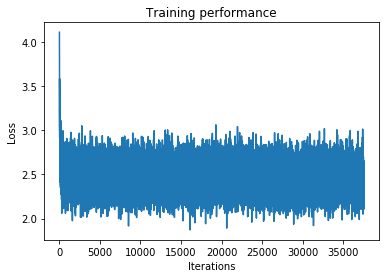

In [9]:
data_set = TextDataset(num_chars=1)
net = OneCharNet().cuda()
trainer = Trainer(net, data_set, num_epochs=4, batch_size=1024)
trainer.train()

## Test the 1-character feed-forward network

By _test_ I really mean _check_, or perhaps, _poke it with a stick_. Let's see what kind of text the model will produce from a seed example. You can see that the results suck, but they're not random noise.

In [10]:
import random

def generate_text(net, data_set, num_chars, length=100, seed='There will be many issues with', choices=1):
    """
    Use the provided `net` model to generate a sequence of characters, based on the seed.
    """
    text = seed.lower()
    for _ in range(length):
        input_text = text[-num_chars:]
        input_idxs = torch.tensor([data_set.char_to_idx[c] for c in input_text]).unsqueeze(dim=0).cuda()
        predictions = net(input_idxs).detach().squeeze().cpu().numpy()
        top_n_idxs = predictions.argsort()[-choices:]
        chosen_idx = random.choice(top_n_idxs)
        chosen_char = data_set.idx_to_char[chosen_idx.item()]
        text += chosen_char
    
    return text

In [11]:
generated_text = generate_text(net, data_set, 1, choices=1)
print(repr(generated_text))

'there will be many issues withe the the the the the the the the the the the the the the the the the the the the the the the the th'


In [12]:
generated_text = generate_text(net, data_set, 1, choices=2)
print(repr(generated_text))

'there will be many issues withis thist t an and athis t thisthist an t at t athin t and at t t thin thisther athinde an the this a'


In [13]:
generated_text = generate_text(net, data_set, 1, choices=3)
print(repr(generated_text))

'there will be many issues wither ase o ofer titis o as o on aseritithin onde o o an of titinde o asthe atinghe onghand and atinghi'


## Define a 2-character feed-forward network

Lets add a 2nd character to the inputs. Now our network:

- takes two characters as an input
- transforms each character integer into an embedding
- runs the 1st char's embedding through a hidden layer
- runs the 2nd char's embedding, plus the 1st hidden layer through another hidden layer
- returns a softmax classification over all possible character classes


```

INPUT            EMBED          DENSE 1            DENSE 2           SOFTMAX

1st char idx --> embedding -->  linear + relu -->  linear + tanh
                                                      |
                                                      v
2nd char idx --> embedding -->  linear + relu -->  linear + tanh --> linear + softmax
                                                                          |
                                                                          v
                                                                     output char idx predictions
```

We can image that the:

- EMBED layer creaties a multi-dimensional representation for each character
- DENSE 1 layer selects important features from the character embeddings
- DENSE 2 layer produces a hidden state, which remembers past observations
- SOFTMAX chooses the next character, based on the hidden state

Looking at this diagram, a question arises: how do we add activations together when reading character 2? There are a few options. We could:

- Add the activations together elementwise
- Concatenate the activations into a new vector

In this case I will concatenate the activations, because using element addition will destroy information. This method seems to help improve the final training loss _a little bit_.

In [14]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # Dense 1
    (2*HIDDEN_PARAMS, HIDDEN_PARAMS),  # Dense 2
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class TwoCharNet(nn.Module):
    def __init__(self):
        super().__init__()        
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.dense_1 = nn.Linear(*LAYERS[1])
        self.dense_2 = nn.Linear(*LAYERS[2])
        self.out = nn.Linear(*LAYERS[3])
        # Functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.softmax = nn.LogSoftmax(dim=1)
                             
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        
        # Run each character through the first dense layer
        dense_1_acts = self.relu(self.dense_1(embed_acts))

        # Initialize the second dense layer activations as all 0s
        batch_size = dense_1_acts.shape[0]
        dense_2_acts = torch.zeros(batch_size, HIDDEN_PARAMS).cuda()
        
        # Run first character activations through second dense layer. 
        char_1 = dense_1_acts[:, 0, :]
        dense_2_in = torch.cat((char_1, dense_2_acts), 1)
        dense_2_acts = self.tanh(self.dense_2(dense_2_in))

        # Run second character activations through second dense layer. 
        char_2 = dense_1_acts[:, 1, :]
        dense_2_in = torch.cat((char_2, dense_2_acts), 1)
        dense_2_acts = self.tanh(self.dense_2(dense_2_in))

        # Make a prediction over character classes given the final dense 2 activations
        prediction = self.softmax(self.out(dense_2_acts))
        return prediction

## Train the 2-character feed-forward network

You can see that using 2 characters instead of one slightly improves our final loss.

epoch 1 / 4, loss: 1.9989


epoch 2 / 4, loss: 2.0585


epoch 3 / 4, loss: 2.0547


epoch 4 / 4, loss: 1.9975


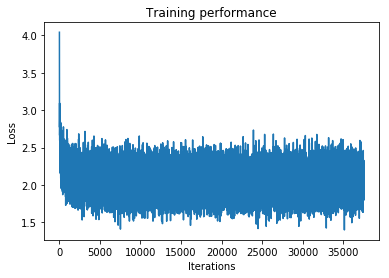

In [15]:
data_set = TextDataset(num_chars=2)
two_char_net = TwoCharNet().cuda()
trainer = Trainer(two_char_net, data_set, num_epochs=4, batch_size=1024)
trainer.train()

## Test the 2-character feed-forward network

It's... slightly better than before.

In [16]:
generated_text = generate_text(two_char_net, data_set, 2, choices=1)
print(generated_text)

there will be many issues withe of the of the of the of the of the of the of the of the of the of the of the of the of the of the 


In [17]:
generated_text = generate_text(two_char_net, data_set, 2, choices=2)
print(generated_text)

there will be many issues witheres and ingen onst istingere torest to by
surestingen ther ther to to be there on of a se tore tor 


In [18]:
generated_text = generate_text(two_char_net, data_set, 2, choices=3)
print(generated_text)

there will be many issues withistraterst toreariess and trin int whave fromencies as asenciestiore faity se thatioreaters he
phe o


## Define an N-character feed-forward network

Lets modify our 2-character network to allow an arbitrary number of characters as inputs. Now our network will now look like this:

```

INPUT            EMBED          DENSE 1            DENSE 2           SOFTMAX

1st char idx --> embedding -->  linear + relu -->  linear + tanh
                                                      |
                                                      v
2nd char idx --> embedding -->  linear + relu -->  linear + tanh
                                                      |
                                                      v
                                                     ...
                                                      |
                                                      v
nth char idx --> embedding -->  linear + relu -->  linear + tanh --> linear + softmax
                                                                          |
                                                                          v
                                                                     output char idx predictions
```

In [19]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # Dense 1
    (2*HIDDEN_PARAMS, HIDDEN_PARAMS),  # Dense 2
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class NCharNet(nn.Module):
    def __init__(self):
        super().__init__()    
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.dense_1 = nn.Linear(*LAYERS[1])
        self.dense_2 = nn.Linear(*LAYERS[2])
        self.out = nn.Linear(*LAYERS[3])
        # Functions
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        
        # Run each character through the first dense layer
        dense_1_acts = self.relu(self.dense_1(embed_acts))
        batch_size, num_chars, num_hidden = dense_1_acts.shape
        
        # Initialize the second dense layer activations as all 0s
        dense_2_acts = torch.zeros(batch_size, num_hidden).cuda()

        # Run each character's activations through second dense layer. 
        for i in range(num_chars):
            char_acts = dense_1_acts[:, i, :]
            dense_2_in = torch.cat((char_acts, dense_2_acts), 1)
            dense_2_acts = self.tanh(self.dense_2(dense_2_in))

        # Make a prediction over character classes given the final dense 2 activations
        prediction = self.softmax(self.out(dense_2_acts))
        return prediction

## Train the N-character feed-forward network

You can see that using more characters continues to improve our final loss. We're also able to train out networks for longer. I also tweaked the batch size here to be smaller. This will take longer to compute, but will probably result in less redundant data per update and thus a better overall loss.

epoch 1 / 4, loss: 1.5621


epoch 2 / 4, loss: 1.5140


epoch 3 / 4, loss: 1.4026


epoch 4 / 4, loss: 1.4533


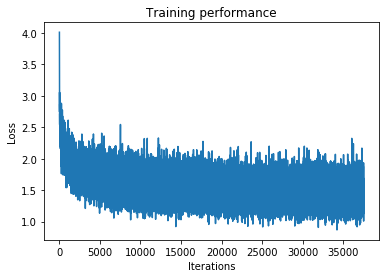

In [20]:
n = 12
data_set = TextDataset(num_chars=n)
n_char_net = NCharNet().cuda()
trainer = Trainer(n_char_net, data_set, num_epochs=4, batch_size=512)
trainer.train()

## Test the N-character feed-forward network

This is the best result so far. It's not _great_ but it's better than the 2-layer network.

In [21]:
generated_text = generate_text(n_char_net, data_set, n, choices=1)
print(generated_text)

there will be many issues with the moral the moral the moral the moral the moral the moral the moral the moral the moral the moral


In [22]:
seed = 'Who is to say what the'
generated_text = generate_text(n_char_net, data_set, n, seed=seed, choices=1)
print(generated_text)

who is to say what the moral the moral the moral the moral the moral the moral the moral the moral the moral the moral the


In [23]:
generated_text = generate_text(n_char_net, data_set, n, choices=2)
print(generated_text)

there will be many issues with a mast of
the
excipates,
than toon to beligion as an
actival and
distrumphanizing,
the
entianists, 


In [24]:
generated_text = generate_text(n_char_net, data_set, n, choices=3)
print(generated_text)

there will be many issues with
seritute,"
is
truibers,
true
ton toongs an all
timing,"
an an exict, as an endusivance, it
in man,



## Using Pytorch's RNN module

You can use a PyTorch module to implement our N-character feed-forward network in fewer lines of code. PyTorch's [RNN class](https://pytorch.org/docs/stable/nn.html#torch.nn.RNN):

- does essentially the same thing as before
- has internal weights for both the input and hidden state
- does not apply a ReLU to the input like we did earlier
- does element-wise addition of input and hidden state by default (not concatenation)

The RNN `forward` function returns two values, which are explained [here](https://stackoverflow.com/questions/48302810/whats-the-difference-between-hidden-and-output-in-pytorch-lstm).

As you can see below, this implementation achieves a similar loss on the training set to `NCharNet`.

In [25]:
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # RNN
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class NCharNetSimplified(nn.Module):
    def __init__(self):
        super().__init__()    
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.rnn = nn.RNN(*LAYERS[1], batch_first=True)
        self.out = nn.Linear(*LAYERS[2])
        
        # Initialize hidden-hidden transition weights to be the identity matrix,
        # to ensure that our hidden-state activations start out stable
        self.rnn.weight_hh_l0.data.copy_(torch.eye(HIDDEN_PARAMS))
        
        # Functions
        self.softmax = nn.LogSoftmax(dim=1)
            
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        batch_size = embed_acts.shape[0]
        
        # Initialize the RNN hidden state activations as all 0s
        hidden_acts = torch.zeros(1, batch_size, HIDDEN_PARAMS).cuda()

        # Run each character's activations through the RNN in sequence.
        rnn_history_acts, _ = self.rnn(embed_acts, hidden_acts)
        rnn_final_acts = rnn_history_acts[:, -1, :].squeeze(dim=1)

        # Make a prediction over character classes given the RNN hidden state activations
        prediction = self.softmax(self.out(rnn_final_acts))
        return prediction

epoch 1 / 4, loss: 1.6898


epoch 2 / 4, loss: 1.5328


epoch 3 / 4, loss: 1.4597


epoch 4 / 4, loss: 1.4586


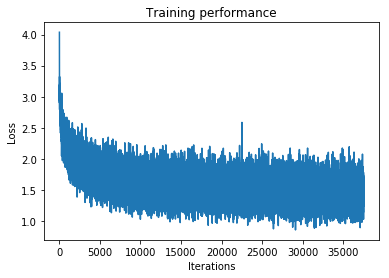

In [26]:
# Train NCharNetSimplified for a few epochs.
n = 12
data_set = TextDataset(num_chars=n)
n_char_net = NCharNetSimplified().cuda()
trainer = Trainer(n_char_net, data_set, num_epochs=4, batch_size=512)
trainer.train()

In [27]:
# Check the model output.
generated_text = generate_text(n_char_net, data_set, n)
print(generated_text)

there will be many issues with the fact to be state of the fact to be state of the fact to be state of the fact to be state of the


# Training more efficiently

One feature of PyTorch's RNN module is that it doesn't just output the last hidden activation of a sequence, it instead outputs a list of predicted activations. That is:

```
IN      CHAR     EMBED       HIDDEN      PREDICT

H  -->  1    --> [.2,.3] --> [.9,.1] --> e
e  -->  42   --> [.4,.1] --> [.8,.2] --> l
l  -->  32   --> [.2,.3] --> [.7,.3] --> l
l  -->  11   --> [.2,.5] --> [.6,.4] --> o
o  -->  9    --> [.5,.3] --> [.5,.5] --> 
   -->  53   --> [.7,.3] --> [.4,.6] --> W
W  -->  52   --> [.4,.1] --> [.3,.7] --> o
o  -->  78   --> [.2,.3] --> [.2,.8] --> r
r  -->  92   --> [.3,.2] --> [.1,.9] --> l
l  -->  31   --> [.1,.7] --> [.1,.1] --> d
                             
```

We can leverage this feature to train our model more efficiently (maybe?). We will also be using this feature in future steps, so we need to update our architecture anyway.

Note that I skipped over the softmax step in the above diagram for simplcity. 

### The problem

Currently for the sentence "Hello World!", and a 5 character window, we would do the following training steps:

```
Hello World! How are you?

Hello[ ]
 ello [W]
  llo W[o]
   lo Wo[r]
    o Wor[l]
      Worl[d]
      World[!]
       ... etc
```

That will be 20 training steps for 25 characters (25 - 5), and this will grow linearly in the number of characters in our  training data: For N characters we will do `N - 5` training steps per epoch.

### An improvement

We can split our training data into non-overlapping segment as follows:

```
Hello World! How are you?

INPUT       PREDICTION

'Hello' --> 'ello '
' Worl' --> 'World'
'd! Ho' --> '! How'
'w are' --> ' are '
' you?' --> 'you? '
```

This is 5 training steps for 25 characters (25 / 5). For N characters we will do `N / 5` traning steps per epoch. 

### Really?

I'm not sure that each update step done using this training method is equivalent to an update step done in the previous "one character at a time" method, so I'm not fully confident that this new method is _actually_ more efficient in terms of wall-clock time spent to get the same result. It definitely chews through epochs more quickly. In any case we need this new architecture for the next step.

### Implementation

We will need to:

- Update our Dataset to return data in segments
- Update our model to return all RNN outputs
- Define a new loss function to handle the output vectors

In [28]:
# Updating our Dataset
class SegmentedTextDataset(TextDataset):
    def __len__(self):
        """
        How many samples there are in the dataset.
        """
        return len(self.text) // self.num_chars - 1

    def __getitem__(self, idx):
        """
        Get item by integer index,
        returns (x_1, x_2, ..., x_n), (x_2, x_3, ..., x_{n+1})
        """
        i = idx * self.num_chars
        inputs = torch.tensor([self.char_to_idx[c] for c in self.text[i:i + self.num_chars]])
        label = torch.tensor([self.char_to_idx[c] for c in self.text[i + 1:i + 1 + self.num_chars]])
        return inputs, label

In [29]:
# Let's check that this works as intended.
train_ds = SegmentedTextDataset(num_chars=4)
print('Source text:', repr(train_ds.text[:20]))
print('Int form:', [train_ds.char_to_idx[c] for c in train_ds.text[:20]])
for i in range(5):
    xs, y = train_ds[i]
    print('Sample', i, '- input', xs, 'label', y)

Source text: 'preface\n\n\nsupposing '
Int form: [42, 44, 31, 32, 27, 29, 31, 0, 0, 0, 45, 47, 42, 42, 41, 45, 35, 40, 33, 1]
Sample 0 - input tensor([42, 44, 31, 32]) label tensor([44, 31, 32, 27])
Sample 1 - input tensor([27, 29, 31,  0]) label tensor([29, 31,  0,  0])
Sample 2 - input tensor([ 0,  0, 45, 47]) label tensor([ 0, 45, 47, 42])
Sample 3 - input tensor([42, 42, 41, 45]) label tensor([42, 41, 45, 35])
Sample 4 - input tensor([35, 40, 33,  1]) label tensor([40, 33,  1, 46])


In [30]:
# Updating our model
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # RNN
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class NCharNetSegmented(nn.Module):
    def __init__(self):
        super().__init__()    
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.rnn = nn.RNN(*LAYERS[1], batch_first=True)
        self.out = nn.Linear(*LAYERS[2])
        
        # Initialize hidden-hidden transition weights to be the identity matrix,
        # to ensure that our hidden-state activations start out stable
        self.rnn.weight_hh_l0.data.copy_(torch.eye(HIDDEN_PARAMS))

        # We want to softmax over the vocab, where the input tensor
        # has the shape (batch x sequence x vocab)
        self.softmax = nn.LogSoftmax(dim=2)
            
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        batch_size = embed_acts.shape[0]
        
        # Initialize the RNN hidden state activations as all 0s
        hidden_acts = torch.zeros(1, batch_size, HIDDEN_PARAMS).cuda()

        # Run each character's activations through the RNN in sequence.
        rnn_acts, _ = self.rnn(embed_acts, hidden_acts)

        # Make a prediction over character classes given the RNN hidden state activations
        prediction = self.softmax(self.out(rnn_acts))
        return prediction

In [31]:
# Create custom loss function
class CrossEntropySequential:
    def __init__(self):
        self.ce =  nn.CrossEntropyLoss()

    def __call__(self, inputs, target):
        """
        Reshape targets and inputs before passing to the loss function.
        
        inputs: batch x seq x vocab => batch*seq x vocab
        target: batch x seq         => batch*seq
        """
        vocab_size = inputs.shape[2]
        flat_inputs = inputs.view(-1, vocab_size)
        flat_target = target.view(-1)
        return self.ce(flat_inputs, flat_target)

epoch 1 / 6, loss: 2.0212


epoch 2 / 6, loss: 1.8071


epoch 3 / 6, loss: 1.7250


epoch 4 / 6, loss: 1.6780


epoch 5 / 6, loss: 1.6975


epoch 6 / 6, loss: 1.6381


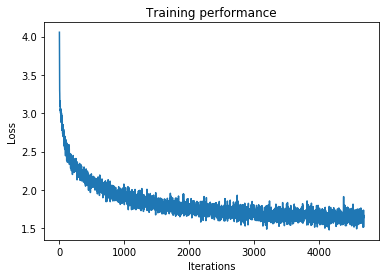

In [32]:
# Train NCharNetSegmented for a few epochs.
n = 12
num_epochs = 6
batch_size = 64

data_set = SegmentedTextDataset(num_chars=n)
criterion = CrossEntropySequential()
n_char_segmented_net = NCharNetSegmented().cuda()
trainer = Trainer(
    n_char_segmented_net,
    data_set,
    num_epochs=num_epochs,
    batch_size=batch_size,
    criterion=criterion
)
trainer.train()

In [33]:
import random

def generate_text_seq(net, data_set, num_chars, length=100, seed='There will be many issues with ', choices=1):
    """
    Use the provided `net` model to generate a sequence of characters, based on the seed.
    """
    text = seed.lower()
    for _ in range(length):
        input_text = text[-num_chars:]
        input_idxs = torch.tensor([data_set.char_to_idx[c] for c in input_text]).unsqueeze(dim=0).cuda()
        predictions = net(input_idxs).detach().squeeze().cpu().numpy()
        top_n_idxs = predictions[-1].argsort()[-choices:]
        chosen_idx = random.choice(top_n_idxs)
        chosen_char = data_set.idx_to_char[chosen_idx.item()]        
        text += chosen_char
    
    return text

In [34]:
generated_text = generate_text_seq(n_char_segmented_net, data_set, n)
print(generated_text)

there will be many issues with the same the same the same the same the same the same the same the same the same the same the same t


# Remembering

Currently our N-character RNN looks at N characters and predicts the N+1th character. When we ask it to predict the N+2th character, it throws away the hidden state from the last prediction and starts again. Our RNN acts as a stateless "pure function": its output is fully determined by its input, independent of what it has seen before. This stateless behaviour is the reason why we get stuck in these stupid loops:

> there will be many issues with the most the same the same the same the same the same the same the same the same the same the same t

Instead of throwing away our history, we can preserve and re-use it inside the RNN, which will hopefully lead to a better language model.

We're going to have to make a couple of changes to our code to accomodate this new stateful RNN.

### Preserve Hidden State

The RNN will need to preserve its hidden state activations between each training batch, so that it can keep track of what it has seen so far.

### Custom Data Loader

Previously each prediction made by our model was independent, so the order of training data didn't matter, but now it does because of the hidden state, which is preserved between batches. Each successive training batch will need to contain the successor text of the last batch. Our input data currently comes out in this format:

```
BATCH   ELEMENT 0        ELEMENT 1 
0       'preface   su'   'pposing that'
1       'truth is a'     ' woman--what'
2       'then? is the'   're not groun'
```

As you can see, element 1 of batch 0 follows element 0 in the same batch. Instead of each batch containing a contiguous sequence of text, we need each _element_ to contain a contiguous sequence, so that our hidden state can be used effectively in training:

```
BATCH   ELEMENT 0        ELEMENT 1 
0       'preface   su'   ' woman--what'
1       'pposing that'   'then? is the'
2       'truth is a'     're not groun'
```

We need to write our own data sampler to ensure that our training data comes out in this element-wise sequential order.

In [35]:
# Custom Sampler
from torch.utils.data.sampler import Sampler

class MultiStreamSampler(Sampler):
    def __init__(self, data_set, batch_size):
        self.stream_size = len(data_set) // batch_size
        self.batch_size = batch_size
                
    def __len__(self):
        return self.stream_size * self.batch_size

    def __iter__(self):
        stream_offsets = [self.stream_size * i for i in range(self.batch_size)]
        count = 0
        while count < self.stream_size:
            for offset in stream_offsets:
                yield offset + count

            count += 1

In [36]:
# Compare our old data loader with the new one
n = 12
batch_size = 2
data_set = SegmentedTextDataset(num_chars=n)
data_set.text = data_set.text[:100]

old_dl = DataLoader(data_set, batch_size=batch_size)

sampler = MultiStreamSampler(data_set, batch_size=batch_size)
new_dl = DataLoader(data_set, batch_size=batch_size, sampler=sampler)

def tensor_to_text(t):
    return ''.join([data_set.idx_to_char[c_int.item()] for c_int in t])

def batch_to_txt(batch):
    inputs, labels = batch
    print([tensor_to_text(el) for el in inputs], '\t', [tensor_to_text(el) for el in labels])

print('Old data loader')
for idx, batch in enumerate(old_dl):
    print(f'batch {idx}: ', end='')
    batch_to_txt(batch)
    
print('New data loader')
for idx, batch in enumerate(new_dl):
    print(f'batch {idx}: ', end='')
    batch_to_txt(batch)

Old data loader
batch 0: ['preface\n\n\nsu', 'pposing that'] 	 ['reface\n\n\nsup', 'posing that ']
batch 1: [' truth is a ', 'woman--what '] 	 ['truth is a w', 'oman--what t']
batch 2: ['then? is the', 're not groun'] 	 ['hen? is ther', 'e not ground']
batch 3: ['d\nfor suspec'] 	 ['\nfor suspect']
New data loader
batch 0: ['preface\n\n\nsu', 'woman--what '] 	 ['reface\n\n\nsup', 'oman--what t']
batch 1: ['pposing that', 'then? is the'] 	 ['posing that ', 'hen? is ther']
batch 2: [' truth is a ', 're not groun'] 	 ['truth is a w', 'e not ground']


In [37]:
# Update our model to remember hidden state between forward passes
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # RNN
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class RememberNet(nn.Module):
    def __init__(self):
        super().__init__()            
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.rnn = nn.RNN(*LAYERS[1], batch_first=True)
        self.out = nn.Linear(*LAYERS[2])
        
        # Initialize hidden-hidden transition weights to be the identity matrix,
        # to ensure that our hidden-state activations start out stable
        self.rnn.weight_hh_l0.data.copy_(torch.eye(HIDDEN_PARAMS))

        # Initialize hidden state
        self.reset_hidden_state(1)
        
        # Functions
        self.softmax = nn.LogSoftmax(dim=2)
        
    def reset_hidden_state(self, batch_size):
        # Initialize the RNN hidden state activations as all 0s
        self.hidden_acts = torch.zeros(1, batch_size, HIDDEN_PARAMS).cuda()
            
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        
        # Account for end-of-epoch batch where final batch size may be smaller
        input_batch_size = embed_acts.shape[0]
        hidden_batch_size = self.hidden_acts.shape[1]
        if input_batch_size != hidden_batch_size:
            self.reset_hidden_state(input_batch_size)
    
        # Run each character's activations through the RNN in sequence.
        rnn_acts, new_hidden_acts = self.rnn(embed_acts, self.hidden_acts)
        
        # Detach hidden activations from their history to prevent a memory leak.
        self.hidden_acts = new_hidden_acts.detach()

        # Make a prediction over character classes given the RNN hidden state activations
        prediction = self.softmax(self.out(rnn_acts))
        return prediction

epoch 1 / 12, loss: 1.8948


epoch 2 / 12, loss: 1.6834


epoch 3 / 12, loss: 1.5837


epoch 4 / 12, loss: 1.5245


epoch 5 / 12, loss: 1.4825


epoch 6 / 12, loss: 1.4535


epoch 7 / 12, loss: 1.4327


epoch 8 / 12, loss: 1.4159


epoch 9 / 12, loss: 1.4013


epoch 10 / 12, loss: 1.3883


epoch 11 / 12, loss: 1.3777


epoch 12 / 12, loss: 1.3692


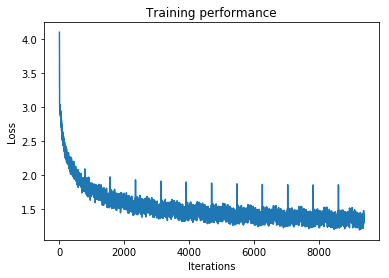

In [38]:
# Train RememberNet for a few epochs.
n = 12
batch_size = 64
num_epochs = 12

data_set = SegmentedTextDataset(num_chars=n)
sampler = MultiStreamSampler(data_set, batch_size=batch_size)
criterion = CrossEntropySequential()
remember_net = RememberNet().cuda()
trainer = Trainer(
    remember_net,
    data_set,
    num_epochs=num_epochs,
    batch_size=batch_size,
    criterion=criterion,
    shuffle=False,
    sampler=sampler
)
trainer.train()

In [39]:
generated_text = generate_text_seq(remember_net, data_set, n)
print(generated_text)

there will be many issues with the sense of the same the sense of the same the sense of the same the sense of the same the sense of


# An den?

In [40]:
# Update our model to remember hidden state between forward passes
import torch.nn as nn

VOCAB_SIZE = len(train_ds.chars)
EMBED_PARAMS = 42
HIDDEN_PARAMS = 256
LAYERS = (
    (VOCAB_SIZE, EMBED_PARAMS),  # Embedding
    (EMBED_PARAMS, HIDDEN_PARAMS),  # RNN
    (HIDDEN_PARAMS, VOCAB_SIZE),  # Output
)

class RememberGRUNet(nn.Module):
    def __init__(self):
        super().__init__()            
        # Parameterized layers
        self.embedding = nn.Embedding(*LAYERS[0])
        self.rnn = nn.GRU(*LAYERS[1], batch_first=True)
        self.out = nn.Linear(*LAYERS[2])
        
        # Initialize hidden-hidden transition weights to be the identity matrix,
        # to ensure that our hidden-state activations start out stable
#         self.rnn.weight_hh_l0.data.copy_(torch.eye(HIDDEN_PARAMS))

        # Initialize hidden state
        self.reset_hidden_state(1)
        
        # Functions
        self.softmax = nn.LogSoftmax(dim=2)
        
    def reset_hidden_state(self, batch_size):
        # Initialize the RNN hidden state activations as all 0s
        self.hidden_acts = torch.zeros(1, batch_size, HIDDEN_PARAMS).cuda()
            
    def forward(self, input_t):
        # Get the embedding for each character
        embed_acts = self.embedding(input_t)
        
        # Account for end-of-epoch batch where final batch size may be smaller
        input_batch_size = embed_acts.shape[0]
        hidden_batch_size = self.hidden_acts.shape[1]
        if input_batch_size != hidden_batch_size:
            self.reset_hidden_state(input_batch_size)
    
        # Run each character's activations through the RNN in sequence.
        rnn_acts, new_hidden_acts = self.rnn(embed_acts, self.hidden_acts)
        
        # Detach hidden activations from their history to prevent a memory leak.
        self.hidden_acts = new_hidden_acts.detach()

        # Make a prediction over character classes given the RNN hidden state activations
        prediction = self.softmax(self.out(rnn_acts))
        return prediction

epoch 1 / 12, loss: 1.6868


epoch 2 / 12, loss: 1.5005


epoch 3 / 12, loss: 1.4195


epoch 4 / 12, loss: 1.3720


epoch 5 / 12, loss: 1.3395


epoch 6 / 12, loss: 1.3150


epoch 7 / 12, loss: 1.2941


epoch 8 / 12, loss: 1.2765


epoch 9 / 12, loss: 1.2612


epoch 10 / 12, loss: 1.2468


epoch 11 / 12, loss: 1.2340


epoch 12 / 12, loss: 1.2238


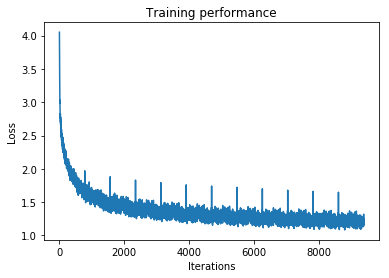

In [41]:
# Train RememberGRUNet for a few epochs.
n = 12
batch_size = 64
num_epochs = 12

data_set = SegmentedTextDataset(num_chars=n)
sampler = MultiStreamSampler(data_set, batch_size=batch_size)
criterion = CrossEntropySequential()
remember_gru_net = RememberGRUNet().cuda()
trainer = Trainer(
    remember_gru_net,
    data_set,
    num_epochs=num_epochs,
    batch_size=batch_size,
    criterion=criterion,
    shuffle=False,
    sampler=sampler,
)
trainer.train()

In [43]:
generated_text = generate_text_seq(remember_gru_net, data_set, n, choices=1, length=300)
# torch.multinomial
print(generated_text)

there will be many issues with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the same with the sa
